In [ ]:
# Packages
import pandas as pd
import torch
from torch.autograd import Variable
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
%matplotlib inline
import pylab
import math
pylab.rcParams['figure.figsize'] = (8.25, 6)

In [ ]:
# Import data
tor_df = pd.read_csv("../tornadoesr/data/raw/tor_train_set_no_zeros.csv")

# Seperating variables
# The outcomes
tornado_outcome = tor_df.iloc[:, [2]]

# The predictors
tornado_predictors = tor_df.iloc[:, 3:]

tor_data = tor_df.iloc[:, 2:].values
tor_data = Variable(torch.from_numpy(tor_data).type(torch.FloatTensor))

In [ ]:
# Define the neural network
class BestNN(torch.nn.Module):
    
    def __init__(self):
        super(BestNN, self).__init__()
        self.fc1 = torch.nn.Linear(tornado_predictors.shape[1], 50)
        self.fc2 = torch.nn.Linear(50, 50)
        self.fc3 = torch.nn.Linear(50, 1)
        
    def forward(self, x):
        x = torch.nn.functional.relu(self.fc1(x))
        x = torch.nn.functional.relu(self.fc2(x))
        x = self.fc3(x)
        return(x)


# Make it
bestnn = BestNN()

In [ ]:
import pyro
from pyro.distributions import Normal, LogNormal, Pareto
from pyro.optim import Adam
from pyro.infer import SVI, Trace_ELBO

# Normal Distribution Priors

In [ ]:
def model(data):
    
    # First layer
    #    We have 51 input variables that go to 50 hidden units (51*50)
    weights_mu_first, weights_sigma_first = (0 * torch.ones(tornado_predictors.shape[1], 50),
                                             1 * torch.ones(tornado_predictors.shape[1], 50))
    #    We have 1 intercept per hidden unit (1*50)
    bias_mu_first, bias_sigma_first = (0 * torch.ones(1, 50),
                                       1 * torch.ones(1, 50))
    
    # Second layer
    #    We have 50 hidden activations that go to 1 output unit
    weights_mu_second, weights_sigma_second = (0 * torch.ones(50, 50),
                                               1 * torch.ones(50, 50))
    #    We have 1 intercept per output unit (1)
    bias_mu_second, bias_sigma_second = (0 * torch.ones(1, 50),
                                         1 * torch.ones(1, 50))
    
    # Third layer
    #    We have 50 hidden activations that go to 1 output unit
    weights_mu_third, weights_sigma_third = (0 * torch.ones(50, 1),
                                             1 * torch.ones(50, 1))
    #    We have 1 intercept per output unit (1)
    bias_mu_third, bias_sigma_third = (0 * torch.ones(1, 1),
                                       1 * torch.ones(1, 1))
    
    
    # For the first layer
    #    Creating and assigning the prior distributions for the weights
    w_priors_first = Normal(weights_mu_first, weights_sigma_first).independent(1)
    #    Creating and assigning the prior distribution for the intercepts
    b_prior_first = Normal(bias_mu_first, bias_sigma_first).independent(1)
    
    # For the second layer
    #    Creating and assiging the prior distributions for the weights
    w_priors_second = Normal(weights_mu_second, weights_sigma_second).independent(1)
    #    Creating and assigning the prior distribution for the intercepts
    b_prior_second = Normal(bias_mu_second, bias_sigma_second).independent(1)
    
    # For the third layer
    #    Creating and assiging the prior distributions for the weights
    w_priors_third = Normal(weights_mu_third, weights_sigma_third).independent(1)
    #    Creating and assigning the prior distribution for the intercepts
    b_prior_third = Normal(bias_mu_third, bias_sigma_third).independent(1)
    
    
    # Putting those into a dictionary
    priors = {'linear.weights_first': w_priors_first,
              'linear.bias_first': b_prior_first,
              'linear.weights_second': w_priors_second,
              'linear.bias_second': b_prior_second,
              'linear.weights_third': w_priors_third,
              'linear.bias_third': b_prior_third}
    
    
    # lift module parameters to random variables sampled from the priors
    # This is like creating the nn.Module (analogy to PyTorch)
    lifted_module = pyro.random_module("module", bestnn, priors)
    # sample a regressor (which also samples w and b)
    # This is like calling the nn.Module (analogy to PyTorch)
    lifted_nn_model = lifted_module()
    
    
    with pyro.iarange("map", 51):
        x_data = tor_data[:, 1:]
        y_data = tor_data[:, 0]

        # run the regressor forward conditioned on data
        prediction_mean = lifted_nn_model(x_data).squeeze(-1)
        
        # condition on the observed data
        pyro.sample("obs",
                    Normal(prediction_mean, 0.1 * torch.ones(data.size(0))),
                    obs=y_data)

Inspect the following chunk, I'm suspicious of the "sig_n" parameters because they seems to be providing a 2nd parameter to the distributions which is likely messing up my Pareto/LogNormal distributions.

In [ ]:
softplus = torch.nn.Softplus()
tanh = torch.nn.Tanh()

def guide(data):
    
    
    # First layer
    #     The weights
    w_mus_first = 0 * torch.ones(tornado_predictors.shape[1], 50)
    w_sigs_first = 1 * torch.ones(tornado_predictors.shape[1], 50)
    #     The intercepts 
    b_mu_first = 0 * torch.ones(1, 50)
    b_sig_first = 1 * torch.ones(1, 50)
    
    # Second layer
    #     The weights
    w_mus_second = 0 * torch.ones(50, 50)
    w_sigs_second = 1 * torch.ones(50, 50)
    #     The intercepts 
    b_mu_second = 0 * torch.ones(1, 50)
    b_sig_second = 1 * torch.ones(1, 50)
    
    # Third layer
    #     The weights
    w_mus_third = 0 * torch.ones(50, 1)
    w_sigs_third = 1 * torch.ones(50, 1)
    #     The intercepts 
    b_mu_third = 0 * torch.ones(1, 1)
    b_sig_third = 1 * torch.ones(1, 1)
    
    
    # Register learnable params in the param store
    # First layer
    #    The weights
    mw_params_first = pyro.param("guide_mean_weights_first", w_mus_first)
    sw_params_first = softplus(pyro.param("guide_std_dev_weights_first", w_sigs_first))
    #    The intercepts
    mb_param_first = pyro.param("guide_mean_bias_first", b_mu_first)
    sb_param_first = softplus(pyro.param("guide_std_dev_bias_first", b_sig_first))
    
    # Second layer
    #    The weights
    mw_params_second = pyro.param("guide_mean_weights_second", w_mus_second)
    sw_params_second = softplus(pyro.param("guide_std_dev_weights_second", w_sigs_second))
    #    The intercepts
    mb_param_second = pyro.param("guide_mean_bias_second", b_mu_second)
    sb_param_second = softplus(pyro.param("guide_std_dev_bias_second", b_sig_second))
    
    # Third layer
    #    The weights
    mw_params_third = pyro.param("guide_mean_weights_third", w_mus_third)
    sw_params_third = tanh(pyro.param("guide_weights_third", w_sigs_third))
    #    The intercepts
    mb_param_third = pyro.param("guide_mean_bias_third", b_mu_third)
    sb_param_third = tanh(pyro.param("guide_std_dev_bias_third", b_sig_third))
    
    
    # guide distributions for w and b
    # First layer
    w_dists_first = Normal(mw_params_first, sw_params_first).independent(1)
    b_dist_first = Normal(mb_param_first, sb_param_first).independent(1)
    # Second layer
    w_dists_second = Normal(mw_params_second, sw_params_second).independent(1)
    b_dist_second = Normal(mb_param_second, sb_param_second).independent(1)
    # Third layer
    w_dists_third = Normal(mw_params_third, sw_params_third).independent(1)
    b_dist_third = Normal(mb_param_third, sb_param_third).independent(1)
    dists = {'linear.weights_first': w_dists_first,
             'linear.bias_first': b_dist_first,
             'linear.weights_second': w_dists_second,
             'linear.bias_second': b_dist_second,
             'linear.weights_third': w_dists_third,
             'linear.bias_second': b_dist_third}
    
    
    # overload the parameters in the module with random samples
    # from the guide distributions
    lifted_module = pyro.random_module("module", bestnn, dists)
    # sample a regressor (which also samples w and b)
    return lifted_module()

In [ ]:
optim = Adam({"weight_decay": 3000})
svi = SVI(model, guide, optim, loss=Trace_ELBO())

In [ ]:
num_iterations = 1000
N = (tor_data.shape[1] - 1)

def main():
    pyro.clear_param_store()
    data_x = tornado_predictors
    data_y = tornado_outcome
    for j in range(num_iterations):
        # calculate the loss and take a gradient step
        loss = svi.step(tor_data)
        if (j) % 250 == 0:
            print("[iteration %04f] loss: %.4f" % ((j+1), loss / float(N)))

if __name__ == '__main__':
    main()

In [ ]:
for name in pyro.get_param_store().get_all_param_names():
    print("\n[%s]: " % (name) + str(pyro.param(name).data.numpy()))
    print("\n[%s]: " % (name) + str(pyro.param(name).shape))

In [ ]:
# Import train data
train_df = pd.read_csv("../tornadoesr/data/raw/tor_train_set_no_zeros.csv")

# Partition the data
train_outcome = train_df.iloc[:, [2]].values
train_predictors = train_df.iloc[:, 3:].values

# Set it up
y_data = Variable(torch.from_numpy(train_outcome).type(torch.FloatTensor))
x_data = Variable(torch.from_numpy(train_predictors).type(torch.FloatTensor))

# Before evaluating
loss = torch.nn.MSELoss()
y_preds = torch.zeros(x_data.shape[0], 1)

stored_preds = np.zeros((100, y_data.shape[0]))

# Evaluating
num_samples_of_param = 100
for i in range(num_samples_of_param):
    # guide does not require the data
    sampled_reg_model = guide(None)
    
    # run the regression model and add prediction to total
    current_y_preds = sampled_reg_model(x_data)
    y_preds = y_preds + current_y_preds
    
    stored_preds[i, :] = current_y_preds.squeeze().data.numpy()
    
# take the average of the predictions
y_preds = y_preds / num_samples_of_param
print ("Loss: ", loss(y_preds, y_data).item())

In [ ]:
tor_data

In [ ]:
conditioned_model = pyro.condition(model, tor_data)

In [ ]:
posterior = pyro.infer.Importance(conditioned_model, guide, num_samples=10)
pyro.infer.EmpiricalMarginal(posterior.run(x_data), site = "prediction_mean")

In [ ]:
stored_preds

In [ ]:
plt.figure(figsize = (11, 8.5))
for i in range(num_samples_of_param):
    plt.scatter(x = stored_preds[i, :],
                y = y_data,
                alpha = 1,
                color = 'blue');
    
average_of_sampled_predictions = np.mean(stored_preds, axis = 0)
plt.scatter(x = average_of_sampled_predictions,
            y = y_data,
            alpha = 1,
            color = 'red',
            edgecolor = 'black')

In [ ]:
np.mean(stored_preds, axis = 0)

In [ ]:
# Import cross-validation data
cv_df = pd.read_csv("../tornadoesr/data/raw/tor_cv_set_no_zeros.csv")

# Partition the data
cv_outcome = cv_df.iloc[:, [2]].values
cv_predictors = cv_df.iloc[:, 3:].values

# Set it up
y_data = Variable(torch.from_numpy(cv_outcome).type(torch.FloatTensor))
x_data = Variable(torch.from_numpy(cv_predictors).type(torch.FloatTensor))

# Set it up
y_preds = torch.zeros(x_data.shape[0], 1)

stored_preds = np.zeros((100, y_data.shape[0]))

# Evaluating
num_samples_of_param = 100
for i in range(num_samples_of_param):
    # guide does not require the data
    sampled_reg_model = guide(None)
    
    # run the regression model and add prediction to total
    current_y_preds = sampled_reg_model(x_data)
    y_preds = y_preds + current_y_preds
    
    stored_preds[i, :] = current_y_preds.squeeze().data.numpy()
    
# take the average of the predictions
y_preds = y_preds / num_samples_of_param
print ("Loss: ", loss(y_preds, y_data).item())

In [ ]:
plt.figure(figsize = (11, 8.5))
for i in range(num_samples_of_param):
    plt.scatter(x = stored_preds[i, :],
                y = y_data,
                alpha = 0.002,
                color = 'red');

<br><br><br><br>

# LogNormal Distribution Priors

In [ ]:
def model(data):
    
    
    # First layer
    #    We have 51 input variables that go to 50 hidden units (51*50)
    weights_scale_first, weights_alpha_first = (-1 * torch.ones(1, tornado_predictors.shape[1]*50),
                                                (1/2 * torch.ones(1, tornado_predictors.shape[1]*50)))
    #    We have 1 intercept per hidden unit (1*50)
    bias_scale_first, bias_alpha_first = (-1 * torch.ones(1, 1*50),
                                          (1/2 * torch.ones(1, 1*50)))
    
    # Second layer
    #    We have 50 hidden activations that go to 1 output unit
    weights_scale_second, weights_alpha_second = (-1 * torch.ones(1, 50*50),
                                                  (1/2 * torch.ones(1, 50*50)))
    #    We have 1 intercept per output unit (1)
    bias_scale_second, bias_alpha_second = (-1 * torch.ones(1, 50*1),
                                            1/2 * torch.ones(1, 50*1))
    
    # Third layer
    #    We have 50 hidden activations that go to 1 output unit
    weights_scale_third, weights_alpha_third = (-1 * torch.ones(1, 1*50),
                                                  (1/2 * torch.ones(1, 1*50)))
    #    We have 1 intercept per output unit (1)
    bias_scale_third, bias_alpha_third = (-1 * torch.ones(1, 1*1),
                                            1/2 * torch.ones(1, 1*1))
    
    
    # For the first layer
    #    Creating and assigning the prior distributions for the weights
    w_priors_first = LogNormal(weights_scale_first, weights_alpha_first).independent(1)
    #    Creating and assigning the prior distribution for the intercepts
    b_prior_first = LogNormal(bias_scale_first, bias_alpha_first).independent(1)
    
    # For the second layer
    #    Creating and assiging the prior distributions for the weights
    w_priors_second = LogNormal(weights_scale_second, weights_alpha_second).independent(1)
    #    Creating and assigning the prior distribution for the intercepts
    b_prior_second = LogNormal(bias_scale_second, bias_alpha_second).independent(1)
    
    # For the third layer
    #    Creating and assiging the prior distributions for the weights
    w_priors_third = LogNormal(weights_scale_third, weights_alpha_third).independent(1)
    #    Creating and assigning the prior distribution for the intercepts
    b_prior_third = LogNormal(bias_scale_third, bias_alpha_third).independent(1)
    
    
    # Putting those into a dictionary
    priors = {'linear.weights_first': w_priors_first,
              'linear.bias_first': b_prior_first,
              'linear.weights_second': w_priors_second,
              'linear.bias_second': b_prior_second,
              'linear.weights_third': w_priors_third,
              'linear.bias_third': b_prior_third}
    
    
    # lift module parameters to random variables sampled from the priors
    # This is like creating the nn.Module (analogy to PyTorch)
    lifted_module = pyro.random_module("module", bestnn, priors)
    # sample a regressor (which also samples w and b)
    # This is like calling the nn.Module (analogy to PyTorch)
    lifted_nn_model = lifted_module()
    
    
    with pyro.iarange("map", 51):
        x_data = tor_data[:, 1:]
        y_data = tor_data[:, 0]

        # run the regressor forward conditioned on data
        prediction_mean = lifted_nn_model(x_data).squeeze(-1)
        
        # condition on the observed data
        pyro.sample("obs",
                    LogNormal(prediction_mean, 0.1 * torch.ones(data.size(0))),
                    obs=y_data)

In [ ]:
softplus = torch.nn.Softplus()
tanh = torch.nn.Tanh()

def guide(data):
    
    
    # First layer
    #     The weights
    w_scales_first = -1 * torch.ones(1, tornado_predictors.shape[1]*50)
    w_log_sigs_first = 1/2 * torch.ones(1, tornado_predictors.shape[1]*50) / 100
    #     The intercepts 
    b_scale_first = -1 * torch.ones(1, 1*50)
    b_log_sig_first = 1/2 * torch.ones(1, 1*50) / 100
    
    # Second layer
    #     The weights
    w_scales_second = -1 * torch.ones(1, 50*50)
    w_log_sigs_second = 1/2 * torch.ones(1, 50*50) / 100
    #     The intercepts 
    b_scale_second = -1 * torch.ones(1, 1*50)
    b_log_sig_second = 1/2 * torch.ones(1, 1*50) / 100
    
    # Third layer
    #     The weights
    w_scales_third = -1 * torch.ones(1, 50*1)
    w_log_sigs_third = 1/2 * torch.ones(1, 50*1) / 100
    #     The intercepts 
    b_scale_third = -1 * torch.ones(1, 1*1)
    b_log_sig_third = 1/2 * torch.ones(1, 1*1) / 100
    
    
    # Register learnable params in the param store
    # First layer
    #    The weights
    mw_params_first = pyro.param("guide_mean_weights_first", w_scales_first)
    sw_params_first = softplus(pyro.param("guide_log_alpha_weights_first", w_log_sigs_first))
    #    The intercepts
    mb_param_first = pyro.param("guide_mean_bias_first", b_scale_first)
    sb_param_first = softplus(pyro.param("guide_log_alpha_bias_first", b_log_sig_first))
    
    # Second layer
    #    The weights
    mw_params_second = pyro.param("guide_mean_weights_second", w_scales_second)
    sw_params_second = softplus(pyro.param("guide_log_alpha_weights_second", w_log_sigs_second))
    #    The intercepts
    mb_param_second = pyro.param("guide_mean_bias_second", b_scale_second)
    sb_param_second = softplus(pyro.param("guide_log_alpha_bias_second", b_log_sig_second))
    
    # Third layer
    #    The weights
    mw_params_third = pyro.param("guide_mean_weights_third", w_scales_third)
    sw_params_third = tanh(pyro.param("guide_log_weights_third", w_log_sigs_third))
    #    The intercepts
    mb_param_third = pyro.param("guide_mean_bias_third", b_scale_third)
    sb_param_third = tanh(pyro.param("guide_log_alpha-bias_second", b_log_sig_third))
    
    
    # guide distributions for w and b
    # First layer
    w_dists_first = LogNormal(mw_params_first, sw_params_first).independent(1)
    b_dist_first = LogNormal(mb_param_first, sb_param_first).independent(1)
    # Second layer
    w_dists_second = LogNormal(mw_params_second, sw_params_second).independent(1)
    b_dist_second = LogNormal(mb_param_second, sb_param_second).independent(1)
    # Third layer
    w_dists_third = LogNormal(mw_params_third, sw_params_third).independent(1)
    b_dist_third = LogNormal(mb_param_third, sb_param_third).independent(1)
    dists = {'linear.weights_first': w_dists_first,
             'linear.bias_first': b_dist_first,
             'linear.weights_second': w_dists_second,
             'linear.bias_second': b_dist_second,
             'linear.weights_third': w_dists_third,
             'linear.bias_second': b_dist_third}
    
    
    # overload the parameters in the module with random samples
    # from the guide distributions
    lifted_module = pyro.random_module("module", bestnn, dists)
    # sample a regressor (which also samples w and b)
    return lifted_module()

In [ ]:
optim = Adam({"weight_decay": 1000})
svi = SVI(model, guide, optim, loss=Trace_ELBO())

In [ ]:
num_iterations = 1000
N = (tor_data.shape[1] - 1)

def main():
    pyro.clear_param_store()
    data_x = tornado_predictors
    data_y = tornado_outcome
    for j in range(num_iterations):
        # calculate the loss and take a gradient step
        loss = svi.step(tor_data)
        if (j) % 250 == 0:
            print("[iteration %04f] loss: %.4f" % ((j+1), loss / float(N)))

if __name__ == '__main__':
    main()

In [ ]:
# Import train data
train_df = pd.read_csv("../tornadoesr/data/raw/tor_train_set_no_zeros.csv")

# Partition the data
train_outcome = train_df.iloc[:, [2]].values
train_predictors = train_df.iloc[:, 3:].values

# Set it up
y_data = Variable(torch.from_numpy(train_outcome).type(torch.FloatTensor))
x_data = Variable(torch.from_numpy(train_predictors).type(torch.FloatTensor))

# Before evaluating
loss = torch.nn.MSELoss()
y_preds = torch.zeros(x_data.shape[0], 1)

stored_preds = np.zeros((100, y_data.shape[0]))

# Evaluating
num_samples_of_param = 100
for i in range(num_samples_of_param):
    # guide does not require the data
    sampled_reg_model = guide(None)
    
    # run the regression model and add prediction to total
    current_y_preds = sampled_reg_model(x_data)
    y_preds = y_preds + current_y_preds
    
    stored_preds[i, :] = current_y_preds.squeeze().data.numpy()
    
# take the average of the predictions
y_preds = y_preds / num_samples_of_param
print ("Loss: ", loss(y_preds, y_data).item())

https://forum.pyro.ai/t/bayesian-rnn-nan-loss-issue/254 has a similar issue and potentially simplified code to use

<br><br><br>

In [ ]:
what_is_this = pyro.nn.MaskedLinear(3, 1, torch.tensor([1, 1, 1]).type(torch.FloatTensor))

In [ ]:
what_is_this(torch.tensor([5, 5, 5]).type(torch.FloatTensor))

In [ ]:
for i in what_is_this.parameters():
    print(i)

<br><br><br><br>

In [1]:
# Packages
import pandas as pd
import torch
from torch.autograd import Variable
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
%matplotlib inline
import pylab
import math
pylab.rcParams['figure.figsize'] = (8.25, 6)

import pyro
from pyro.distributions import Normal, LogNormal, Pareto
from pyro.optim import Adam
from pyro.infer import SVI, Trace_ELBO

In [2]:
# Import data
tor_df = pd.read_csv("../tornadoesr/data/raw/tor_train_set_no_zeros.csv")

# Seperating variables
# The outcomes
tornado_outcome = tor_df.iloc[:, [2]]

# The predictors
tornado_predictors = tor_df.iloc[:, 3:]

tor_data = tor_df.iloc[:, 2:].values
tor_data = Variable(torch.from_numpy(tor_data).type(torch.FloatTensor))

In [3]:
class Net(torch.nn.Module):
    def __init__(self, n_feature, n_hidden):
        super(Net, self).__init__()
        self.hidden = torch.nn.Linear(n_feature, n_hidden)   # hidden layer
        self.predict = torch.nn.Linear(n_hidden, 1)   # output layer

    def forward(self, x):
        x = self.hidden(x)
        x = self.predict(x)
        return x

first_layer = tornado_predictors.shape[1]
second_layer = 50
    
softplus = torch.nn.Softplus()
regression_model = Net(first_layer, second_layer)

In [4]:
N = tornado_predictors.shape[0]
N

8652

In [5]:
def model(data):

    mu = Variable(torch.zeros(second_layer, first_layer)).type_as(data)
    sigma = Variable(torch.ones(second_layer, first_layer)).type_as(data)
    bias_mu = Variable(torch.zeros(second_layer)).type_as(data)
    bias_sigma = Variable(torch.ones(second_layer)).type_as(data)
    w_prior, b_prior = Normal(mu, sigma), Normal(bias_mu, bias_sigma)
    
    mu2 = Variable(torch.zeros(1, second_layer)).type_as(data)
    sigma2 = Variable(torch.ones(1, second_layer)).type_as(data)
    bias_mu2 = Variable(torch.zeros(1)).type_as(data)
    bias_sigma2 = Variable(torch.ones(1)).type_as(data)
    w_prior2, b_prior2 = Normal(mu2, sigma2), Normal(bias_mu2, bias_sigma2)    
    
    priors = {'hidden.weight': w_prior, 
              'hidden.bias': b_prior,
              'predict.weight': w_prior2,
              'predict.bias': b_prior2}
    
    # lift module parameters to random variables sampled from the priors
    lifted_module = pyro.random_module("module", regression_model, priors)
    # sample a regressor (which also samples w and b)
    lifted_reg_model = lifted_module()

    with pyro.iarange("map", N, subsample=data):
        x_data = data[:, 1:]
        y_data = data[:, 0]
        # run the regressor forward conditioned on inputs
        prediction_mean = lifted_reg_model(x_data).squeeze()
        pyro.sample("obs",
                    Normal(prediction_mean, Variable(torch.ones(data.size(0))).type_as(data)),
                    obs=y_data.squeeze())
        

def guide(data):
    
    w_mu = Variable(torch.randn(second_layer, first_layer).type_as(data.data), requires_grad=True)
    w_log_sig = Variable(0.1 * torch.ones(second_layer, first_layer).type_as(data.data), requires_grad=True)
    b_mu = Variable(torch.randn(second_layer).type_as(data.data), requires_grad=True)
    b_log_sig = Variable(0.1 * torch.ones(second_layer).type_as(data.data), requires_grad=True)
    
    # register learnable params in the param store
    mw_param = pyro.param("guide_mean_weight", w_mu)
    sw_param = softplus(pyro.param("guide_log_sigma_weight", w_log_sig))
    mb_param = pyro.param("guide_mean_bias", b_mu)
    sb_param = softplus(pyro.param("guide_log_sigma_bias", b_log_sig))
    
    # gaussian guide distributions for w and b
    w_dist = Normal(mw_param, sw_param)
    b_dist = Normal(mb_param, sb_param)
    
    w_mu2 = Variable(torch.randn(1, second_layer).type_as(data.data), requires_grad=True)
    w_log_sig2 = Variable(0.1 * torch.randn(1, second_layer).type_as(data.data), requires_grad=True)
    b_mu2 = Variable(torch.randn(1).type_as(data.data), requires_grad=True)
    b_log_sig2 = Variable(0.1 * torch.ones(1).type_as(data.data), requires_grad=True)
    
    # register learnable params in the param store
    mw_param2 = pyro.param("guide_mean_weight2", w_mu2)
    sw_param2 = softplus(pyro.param("guide_log_sigma_weight2", w_log_sig2))
    mb_param2 = pyro.param("guide_mean_bias2", b_mu2)
    sb_param2 = softplus(pyro.param("guide_log_sigma_bias2", b_log_sig2))
    
    # gaussian guide distributions for w and b
    w_dist2 = Normal(mw_param2, sw_param2)
    b_dist2 = Normal(mb_param2, sb_param2)
      
    dists = {'hidden.weight': w_dist, 
              'hidden.bias': b_dist,
              'predict.weight': w_dist2,
              'predict.bias': b_dist2}
    
    # overloading the parameters in the module with random samples from the guide distributions
    lifted_module = pyro.random_module("module", regression_model, dists)
    # sample a regressor
    return lifted_module()

In [6]:
# instantiate optim and inference objects# instan 
optim = Adam({"lr": 0.01})
svi = SVI(model, guide, optim, loss=Trace_ELBO())

data = tor_data

for j in range(10000):
    epoch_loss = svi.step(data)
    if j % 100 == 0:
        print(j, "avg loss {}".format(epoch_loss))

0 avg loss 17739779.618939757
100 avg loss 5300048.997527182
200 avg loss 2806330.7715301514
300 avg loss 3078455.7956335545
400 avg loss 1717856.7328053713
500 avg loss 974235.1472401619
600 avg loss 469058.40980136395
700 avg loss 743765.1863851547
800 avg loss 249943.1790510416
900 avg loss 655969.7478789687
1000 avg loss 351069.03041261435
1100 avg loss 125982.16829931736
1200 avg loss 242014.69765913486
1300 avg loss 272439.28184366226
1400 avg loss 104616.49492555857
1500 avg loss 90093.91927587986
1600 avg loss 158725.49202775955
1700 avg loss 206298.95590281487
1800 avg loss 150503.42205440998
1900 avg loss 50595.13635802269
2000 avg loss 119484.02208077908
2100 avg loss 81231.35544645786
2200 avg loss 55759.90158712864
2300 avg loss 61697.92832171917
2400 avg loss 48158.58571565151
2500 avg loss 40074.032284498215
2600 avg loss 36444.727288126945
2700 avg loss 45643.84373533726
2800 avg loss 41977.985267043114
2900 avg loss 47941.51788067818
3000 avg loss 36310.498942017555
31

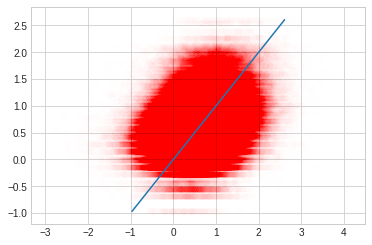

In [7]:
preds = []
for i in range(100):
    sampled_reg_model = guide(tor_data[:, 1:])
    pred = sampled_reg_model(tor_data[:, 1:]).data.numpy().flatten()
    plt.scatter(x = pred, y = tornado_outcome.values, alpha = 0.0025, color = 'red')
    preds.append(pred)
    
preds = np.array(preds)
mean = np.mean(preds, axis=0)

plt.plot([tornado_outcome.values.min(), tornado_outcome.values.max()],
         [tornado_outcome.values.min(), tornado_outcome.values.max()]);

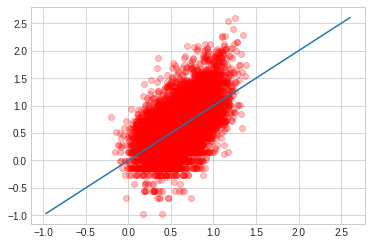

In [8]:
plt.scatter(x = mean, y = tornado_outcome.values, alpha = 0.25, color = 'red')
plt.plot([tornado_outcome.values.min(), tornado_outcome.values.max()],
         [tornado_outcome.values.min(), tornado_outcome.values.max()]);

In [9]:
X_test = Variable(torch.from_numpy(cv_predictors).type(torch.FloatTensor))
Y_test = Variable(torch.from_numpy(cv_outcome).type(torch.FloatTensor))

NameError: name 'cv_predictors' is not defined

In [10]:
preds = []
for i in range(100):
    sampled_reg_model = guide(X_test)
    pred = sampled_reg_model(X_test).data.numpy().flatten()
    preds.append(pred)

preds = np.array(preds)
mean = np.mean(preds, axis=0)
std = np.std(preds, axis=0) / 10
y_test = Y_test.data.numpy()
x = np.arange(len(y_test))

plt.figure()
plt.plot(x, mean, linestyle = '--', color = 'red')

plt.plot(x, y_test, color = 'black')
plt.fill_between(x, mean-std, mean+std, alpha = 0.3, color = 'orange')
plt.show()

NameError: name 'X_test' is not defined

In [ ]:
plt.scatter(mean, y_test)

In [ ]:
sampled_reg_model = guide(X_test)
pred = sampled_reg_model(X_test).data.numpy().flatten()
pred